# text embeddings + conceptual axes

In [1]:
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
import torch
import torch.nn.functional as F
import textwrap

import plotly.express as px
import plotly.graph_objects as go



In [2]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [3]:

tokenizer = AutoTokenizer.from_pretrained('Qwen/Qwen3-Embedding-0.6B')
model = AutoModel.from_pretrained('Qwen/Qwen3-Embedding-0.6B')

model.eval()

Qwen3Model(
  (embed_tokens): Embedding(151669, 1024)
  (layers): ModuleList(
    (0-27): 28 x Qwen3DecoderLayer(
      (self_attn): Qwen3Attention(
        (q_proj): Linear(in_features=1024, out_features=2048, bias=False)
        (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
        (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
        (o_proj): Linear(in_features=2048, out_features=1024, bias=False)
        (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
        (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
      )
      (mlp): Qwen3MLP(
        (gate_proj): Linear(in_features=1024, out_features=3072, bias=False)
        (up_proj): Linear(in_features=1024, out_features=3072, bias=False)
        (down_proj): Linear(in_features=3072, out_features=1024, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
      (post_attention_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
    )
  )
  (norm): Qwen3RMSNorm((102

In [4]:
axes_map = {'social_issues': ['justice', 'equality', 'rights', 'fairness', 'discrimination', 'prejudice', 'persecution', 'humanity', 'dignity', 'compassion', 'liberty', 'protection', 'civil rights', 'human rights', 'alien', 'person', 'power', 'unconstitutional'],
            'economics': ['economy', 'economic', 'labor', 'commerce', 'trade', 'industry', 'railway', 'development', 'profit', 'wages', 'capital', 'prosperity', 'cheap labor', 'economic necessity', 'business', 'license', 'tax', 'fee', 'revenue', 'labour', 'employment', 'wage', 'miner', 'mining', 'land', 'goods', 'property', 'economic', 'industry', 'regulate', 'forfeit', 'penalty', 'pay']}

In [5]:
df = pd.read_csv("../data/metadata.csv")

df.head()

,filename,author,type,text
0,regina_v_wing_chong.txt,Crease,case,"CREASE, J. 1885. REGINA v. WING CHONG. \r\n\r\..."
1,wong_hoy_woon_v_duncan.txt,Crease,case,"CREASE, J.\r\n\r\nWONG HOY WOON v. DUNCAN.\r\n..."
2,regina_v_mee_wah.txt,Begbie,case,BRITISH COLUMBIA REPORTS.\r\n\r\nREGINA v. MEE...
3,regina_v_victoria.txt,Begbie,case,"OF BRITISH COLUMBIA.\r\n\r\nREGINA r, CORPORAT..."
4,quong_wing_v_the_king.txt,Fitzpatrick,case,QUONG WING v. THE KING. CAN. \r\n\r\nSupreme ...


In [6]:
crease_texts = df[df['author'] == 'Crease']['text'].tolist()
begbie_texts = df[df['author'] == 'Begbie']['text'].tolist()
other_texts = df[df['author'] =='Others']['text'].tolist() # the chinese regulation act -- much more racist

judge_dict = {
    'Crease': crease_texts,
    'Begbie': begbie_texts,
    'other': other_texts}

In [ ]:
import torch

import torch

def get_mean_embedding(text, model, tokenizer):

    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)

    last_hidden_state = outputs.last_hidden_state
    attention_mask = inputs['attention_mask']s
    mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.shape).float()
    masked_embeddings = last_hidden_state * mask
    
    summed_embeddings = torch.sum(masked_embeddings, dim=1)
    summed_mask = torch.clamp(mask.sum(dim=1), min=1e-9)
    mean_embedding = summed_embeddings / summed_mask

    return mean_embedding.squeeze().cpu().numpy()

In [7]:
def get_token_embedding(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=32768, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    
    attention_mask = inputs['attention_mask']
    last_token_index = attention_mask.sum(dim=1) - 1
    
    batch_size = outputs.last_hidden_state.shape[0]
    last_token_index = last_token_index.unsqueeze(-1).expand(-1, outputs.last_hidden_state.shape[-1]).unsqueeze(1)
    last_token_embedding = torch.gather(outputs.last_hidden_state, 1, last_token_index).squeeze(1)

    return last_token_embedding.squeeze().cpu().numpy()

In [8]:
import numpy as np

def create_axis_vector(keywords, corpus_texts, model, tokenizer, get_embedding_for_text):
    context_sentences = []

    for doc in corpus_texts:
        sentences = [s.strip() for s in doc.split('.') if len(s.strip()) > 10]
        for sentence in sentences:
            if any(keyword in sentence.lower() for keyword in keywords):
                context_sentences.append(sentence)

    context_embeddings = [get_embedding_for_text(sent, model, tokenizer) for sent in context_sentences]
    axis_vector = np.mean(context_embeddings, axis=0)
    axis_vector_normalized = axis_vector / np.linalg.norm(axis_vector)
    
    return axis_vector_normalized

In [10]:
all_texts = df['text'].tolist()

contextual_social_axis = create_axis_vector(keywords=axes_map['social_issues'],corpus_texts=all_texts,model=model,tokenizer=tokenizer,get_embedding_for_text=get_token_embedding )

contextual_economic_axis = create_axis_vector(keywords=axes_map['economics'],corpus_texts=all_texts,model=model,tokenizer=tokenizer,get_embedding_for_text=get_token_embedding )


In [12]:
results = []
print("Processing texts and projecting onto axes...")

for judge, texts in judge_dict.items():
    for text in texts:
        sentences = [s.strip() for s in text.split('.') if len(s.strip()) > 10] 

        for sentence in sentences:
            sentence_embedding = get_token_embedding(sentence, model, tokenizer)
        
            sentence_vec = sentence_embedding.reshape(1, -1)
            social_axis_vec = contextual_social_axis.reshape(1, -1)
            econ_axis_vec = contextual_economic_axis.reshape(1, -1)

            social_score = cosine_similarity(sentence_vec, social_axis_vec)[0][0]
            econ_score = cosine_similarity(sentence_vec, econ_axis_vec)[0][0]
            
            results.append({'Judge': judge,
                'Sentence': sentence,
                'Social_Score': social_score,
                'Econ_Score': econ_score})
results_df = pd.DataFrame(results)

print(results_df.head())


Processing texts and projecting onto axes...
    Judge                                           Sentence  Social_Score  \
0  Crease  14th & 15th July, Certiorari—“Chinese Regulati...      0.508067   
1  Crease                              5—Constitutionality—B      0.608031   
2  Crease                                      Act, 1867, ss      0.485626   
3  Crease      91, 92—“Aliens”—“Trade and Commerce”—Taxation      0.574100   
4  Crease              On the return to a writ of certiorari      0.558319   

   Econ_Score  
0    0.464876  
1    0.559656  
2    0.506376  
3    0.593997  
4    0.537475  


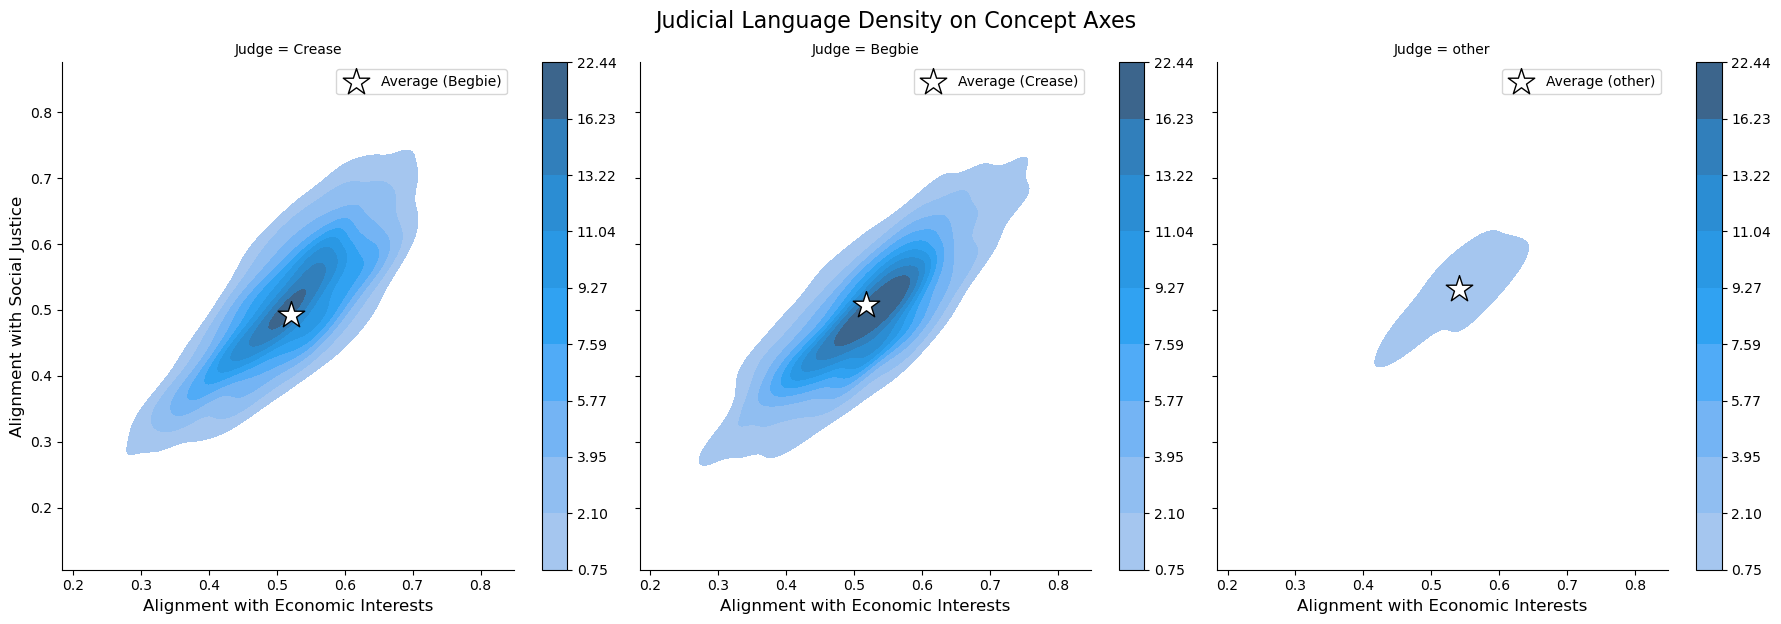

In [13]:
results_df = pd.DataFrame(results)

aggregate_scores = results_df.groupby('Judge')[['Social_Score', 'Econ_Score']].mean()


g = sns.displot(
    data=results_df,
    x='Econ_Score',
    y='Social_Score',
    col='Judge',        
    kind='kde',         # Using Kernel Density Estimate 
    fill=True,          
    cbar=True,         
    height=6,           
    aspect=1           
)

for i, judge_name in enumerate(aggregate_scores.index):
    ax = g.axes.flat[i]
    avg_scores = aggregate_scores.loc[judge_name]
    
    ax.scatter(
        avg_scores['Econ_Score'],
        avg_scores['Social_Score'],
        s=400,
        marker='*',
        color='white',
        edgecolor='black',
        label=f'Average ({judge_name})' )
    ax.legend()

g.fig.suptitle('Judicial Language Density on Concept Axes', y=1.03, fontsize=16)
g.set_axis_labels('Alignment with Economic Interests', 'Alignment with Social Justice', fontsize=12)

plt.show()

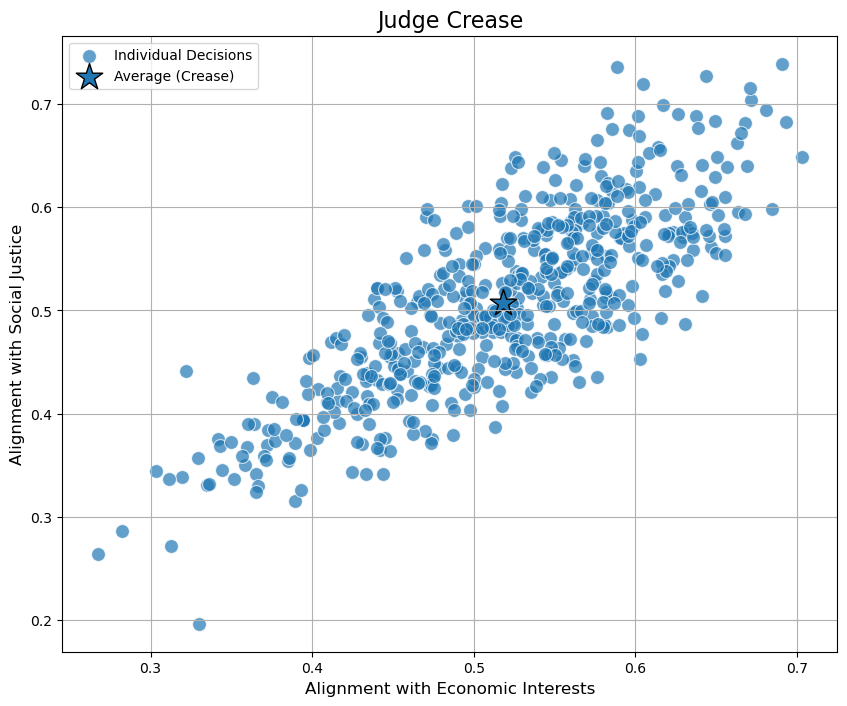

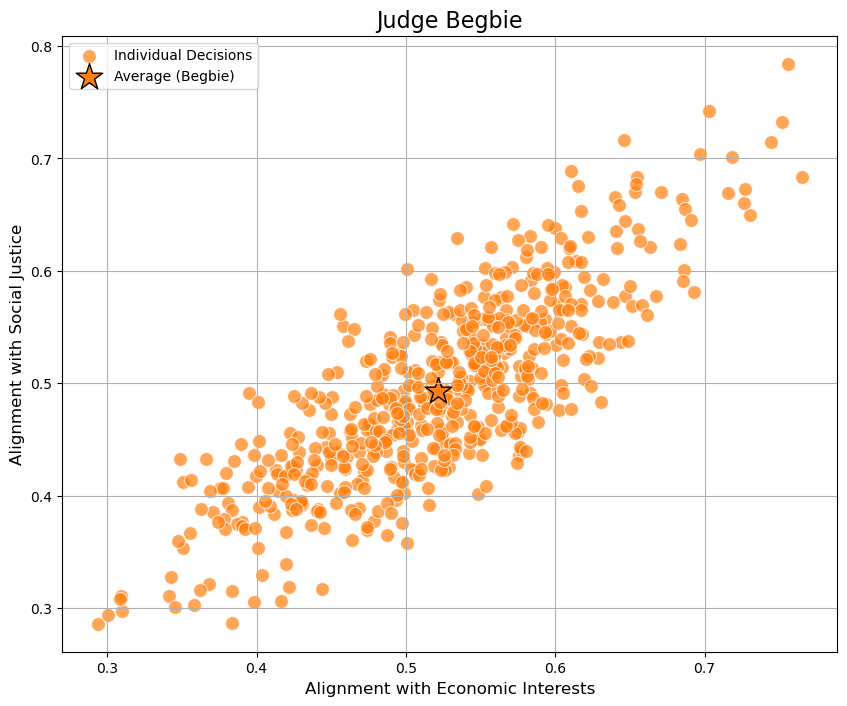

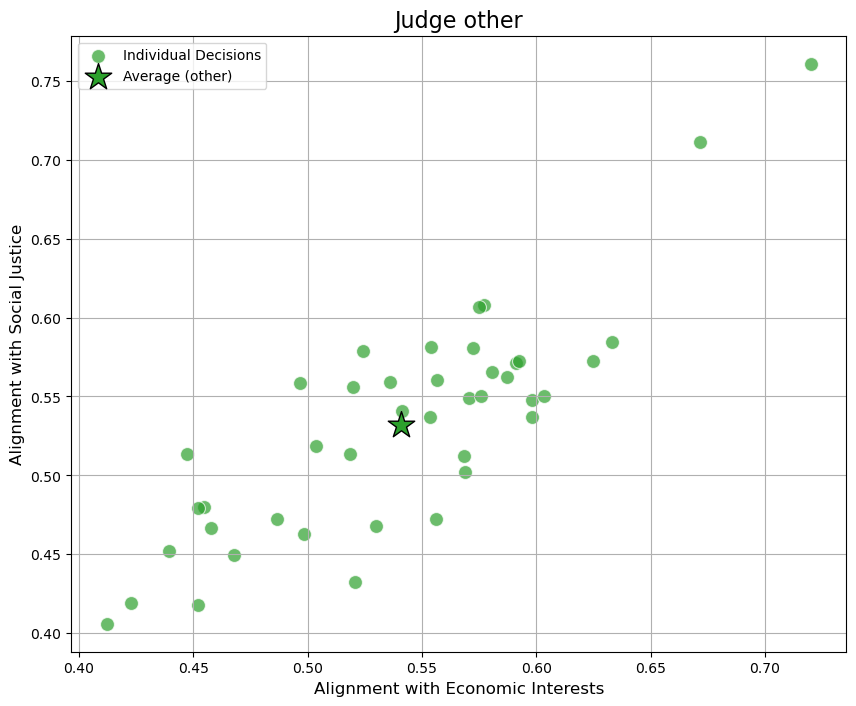

In [14]:
judges = results_df['Judge'].unique()

palette = sns.color_palette()

for i, judge_name in enumerate(judges):
    fig, ax = plt.subplots(figsize=(10, 8))
    judge_data = results_df[results_df['Judge'] == judge_name]
    sns.scatterplot(
        data=judge_data,
        x='Econ_Score',
        y='Social_Score',
        s=100,
        alpha=0.7,
        ax=ax,
        color=palette[i % len(palette)],
        label='Individual Decisions')
    
    avg_scores = aggregate_scores.loc[judge_name]
    ax.scatter(
        avg_scores['Econ_Score'], 
        avg_scores['Social_Score'], 
        s=400, 
        marker='*', 
        edgecolor='black', 
        label=f'Average ({judge_name})',
        c=[palette[i % len(palette)]])
    
    ax.set_title(f'Judge {judge_name}', fontsize=16)
    ax.set_xlabel('Alignment with Economic Interests', fontsize=12)
    ax.set_ylabel('Alignment with Social Justice', fontsize=12)
    ax.legend()
    ax.grid(True)
    
    plt.show()

In [15]:
from transformers import pipeline 
print("Loading sentiment analysis model...")
sentiment_pipeline = pipeline(
    'sentiment-analysis', 
    model='distilbert-base-uncased-finetuned-sst-2-english'
)

sentiments = []

for sentence in tqdm(results_df['Sentence']):
    result = sentiment_pipeline(sentence)[0]
    
    score = result['score']
    if result['label'] == 'NEGATIVE':
        score = -score
    else: score = score
    sentiments.append(score)

results_df['Sentiment'] = sentiments

print("\nSentiment analysis complete.")
print(results_df.head())

Loading sentiment analysis model...


Device set to use cpu


NameError: name 'tqdm' is not defined

In [ ]:

print(results_df.groupby('Judge')[['Econ_Score', 'Social_Score', 'Sentiment']].count())

        Econ_Score  Social_Score  Sentiment
Judge                                      
Begbie         581           581        581
Crease         561           561        561
other           42            42         42


In [136]:
print(pd.crosstab(results_df['Judge'], results_df['Sentiment']))

Sentiment   -1    1
Judge              
Begbie     414  167
Crease     376  185
other       37    5


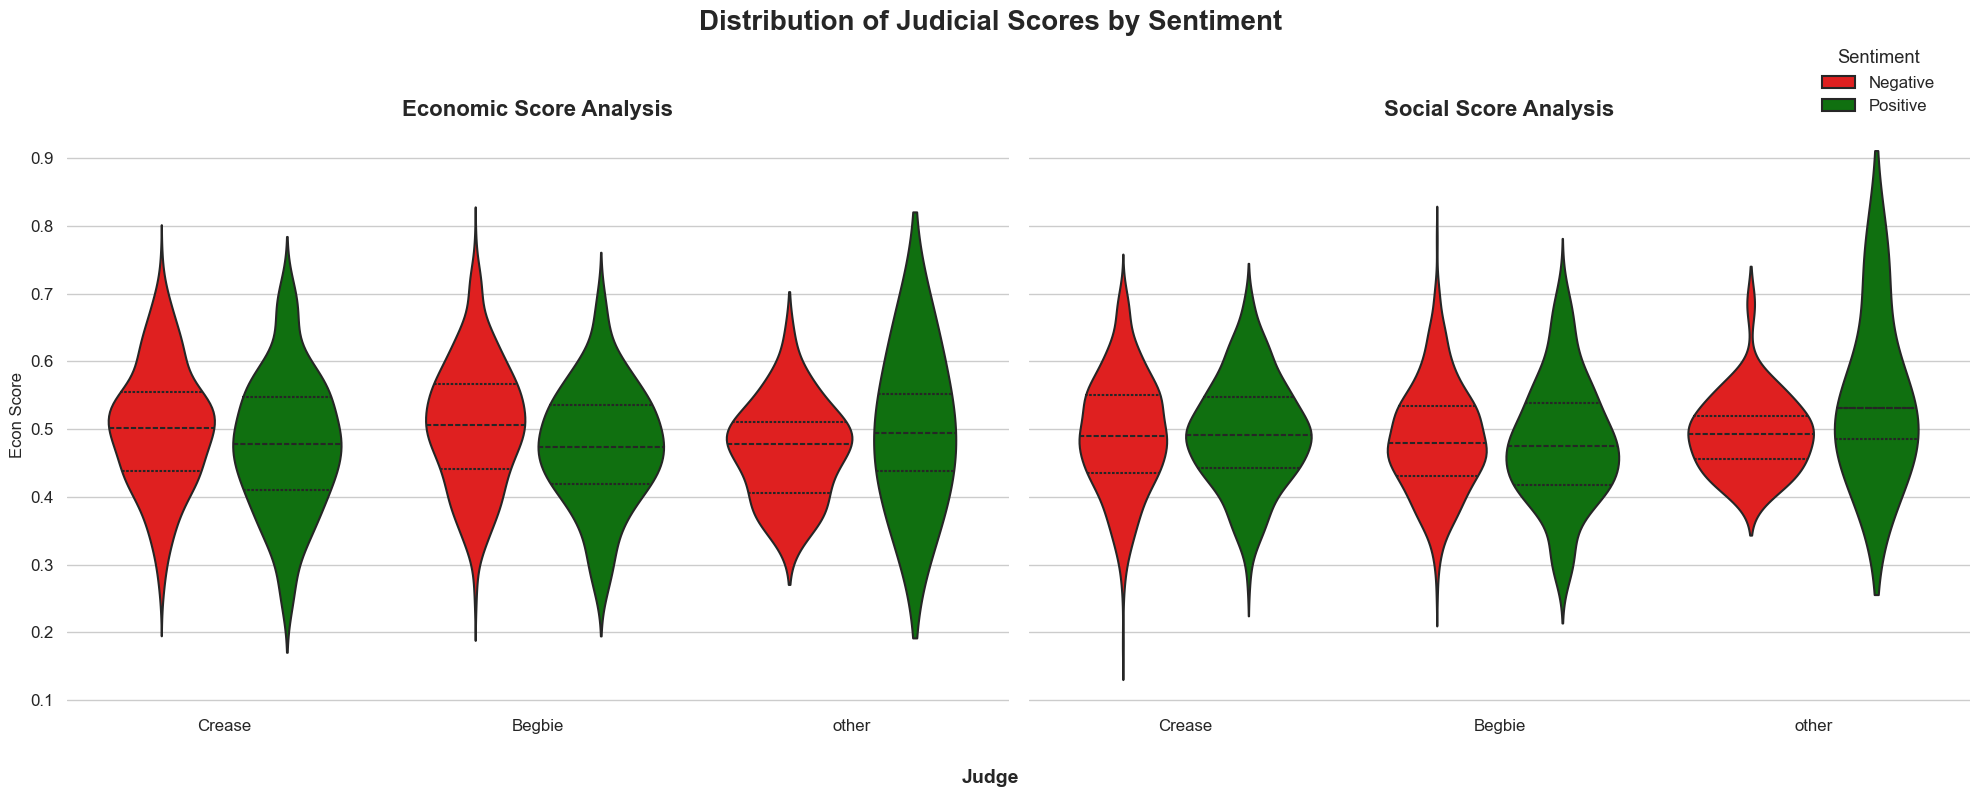

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def plot_score_distribution(ax, data, score_col, title):
    sentiment_palette = {1: "green", -1: "red"} 
    
    sns.violinplot(
        data=data,
        x='Judge',
        y=score_col,
        hue='Sentiment',
        split=False,
        inner='quartile',
        palette=sentiment_palette,
        linewidth=1.5,
        ax=ax
    )
    
    ax.set_title(title, fontsize=16, weight='bold')
    ax.set_ylabel(f"{score_col.replace('_', ' ')}", fontsize=12)
    ax.set_xlabel(None) 
    ax.get_legend().remove() 
    
sns.set_theme(style="whitegrid", font_scale=1.1)
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
fig.suptitle('Distribution of Judicial Scores by Sentiment', fontsize=20, weight='bold')


plot_score_distribution(
    ax=axes[0], 
    data=results_df, 
    score_col='Econ_Score', 
    title='Economic Score Analysis')
plot_score_distribution(
    ax=axes[1], 
    data=results_df, 
    score_col='Social_Score', 
    title='Social Score Analysis')

fig.text(0.5, 0.02, 'Judge', ha='center', va='center', fontsize=14, weight='bold')
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, ['Negative', 'Positive'], title='Sentiment', loc='upper right', bbox_to_anchor=(0.98, 0.95))
sns.despine(left=True, bottom=True)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

In [16]:
neg_df = pd.read_csv("words_negative.csv") 
pos_df = pd.read_csv("words_positive.csv")
negative_words = neg_df.iloc[:, 0].dropna().tolist()
positive_words = pos_df.iloc[:, 0].dropna().tolist()

sentiment_map = {
    "negative": negative_words,
    "positive": positive_words}

In [19]:
pos_axis = create_axis_vector(keywords=sentiment_map['positive'],corpus_texts=all_texts,model=model,tokenizer=tokenizer,get_embedding_for_text=get_token_embedding )

neg_axis = create_axis_vector(keywords=sentiment_map['negative'],corpus_texts=all_texts,model=model,tokenizer=tokenizer,get_embedding_for_text=get_token_embedding )

In [21]:
results = []
print("Processing texts and projecting onto axes...")

for judge, texts in judge_dict.items():
    for text in texts:
        sentences = [s.strip() for s in text.split('.') if len(s.strip()) > 10] 

        for sentence in sentences:
            sentence_embedding = get_token_embedding(sentence, model, tokenizer)
        
            sentence_vec = sentence_embedding.reshape(1, -1)
            pos_axis_vec = pos_axis.reshape(1, -1)
            neg_axis_vec = neg_axis.reshape(1, -1)

            positive_score = cosine_similarity(sentence_vec, pos_axis_vec)[0][0]
            negative_score = cosine_similarity(sentence_vec, neg_axis_vec)[0][0]
            
            results.append({'Judge': judge,
                'Sentence': sentence,
                'Positive_Score': positive_score,
                'Negative_Score': negative_score})
results_sent = pd.DataFrame(results)

print(results_sent.head())

Processing texts and projecting onto axes...
    Judge                                           Sentence  Positive_Score  \
0  Crease  14th & 15th July, Certiorari—“Chinese Regulati...        0.477629   
1  Crease                              5—Constitutionality—B        0.600105   
2  Crease                                      Act, 1867, ss        0.537516   
3  Crease      91, 92—“Aliens”—“Trade and Commerce”—Taxation        0.566090   
4  Crease              On the return to a writ of certiorari        0.586729   

   Negative_Score  
0        0.482741  
1        0.611824  
2        0.543778  
3        0.580658  
4        0.592425  


In [22]:
all_scores = pd.merge(results_df, results_sent, on=['Judge', 'Sentence'])
all_scores['Sentiment_Score'] = all_scores['Positive_Score'] - all_scores['Negative_Score']

final_df = all_scores[['Judge', 'Sentence', 'Econ_Score', 'Social_Score', 'Sentiment_Score']]
final_df = final_df.rename(columns={
    'Econ_Score': 'Economic_Alignment_Score',
    'Social_Score': 'Social_Score'})

print(final_df.head())

    Judge                                           Sentence  \
0  Crease  14th & 15th July, Certiorari—“Chinese Regulati...   
1  Crease                              5—Constitutionality—B   
2  Crease                                      Act, 1867, ss   
3  Crease      91, 92—“Aliens”—“Trade and Commerce”—Taxation   
4  Crease              On the return to a writ of certiorari   

   Economic_Alignment_Score  Social_Score  Sentiment_Score  
0                  0.464876      0.508067        -0.005112  
1                  0.559656      0.608031        -0.011718  
2                  0.506376      0.485626        -0.006262  
3                  0.593997      0.574100        -0.014568  
4                  0.537475      0.558319        -0.005695  


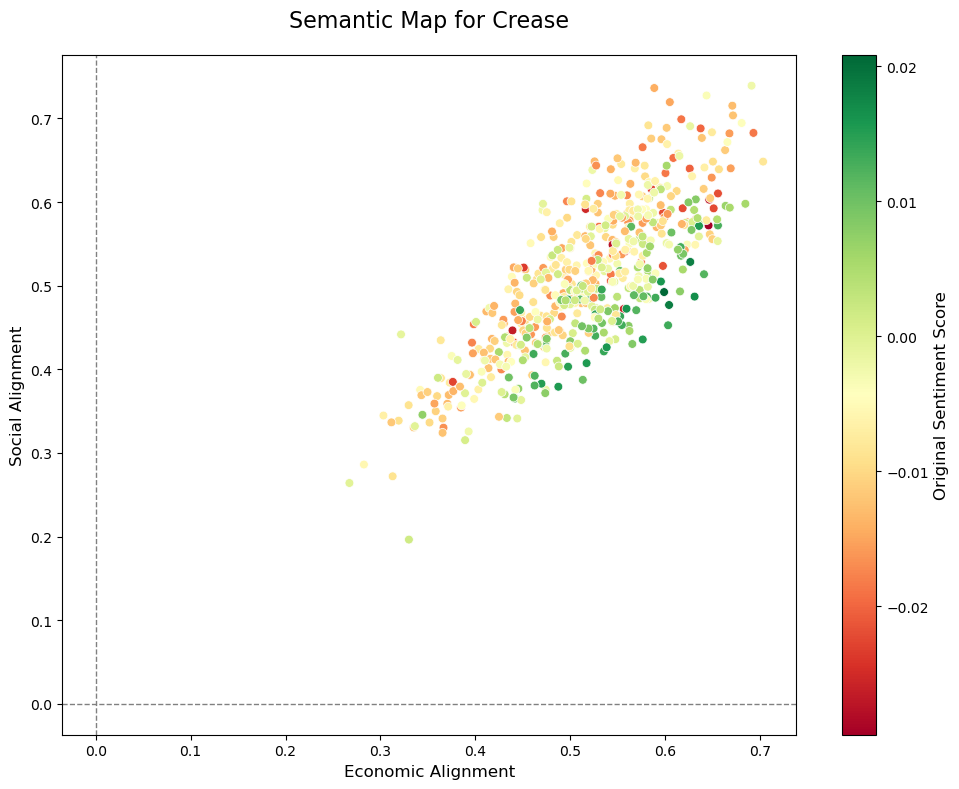

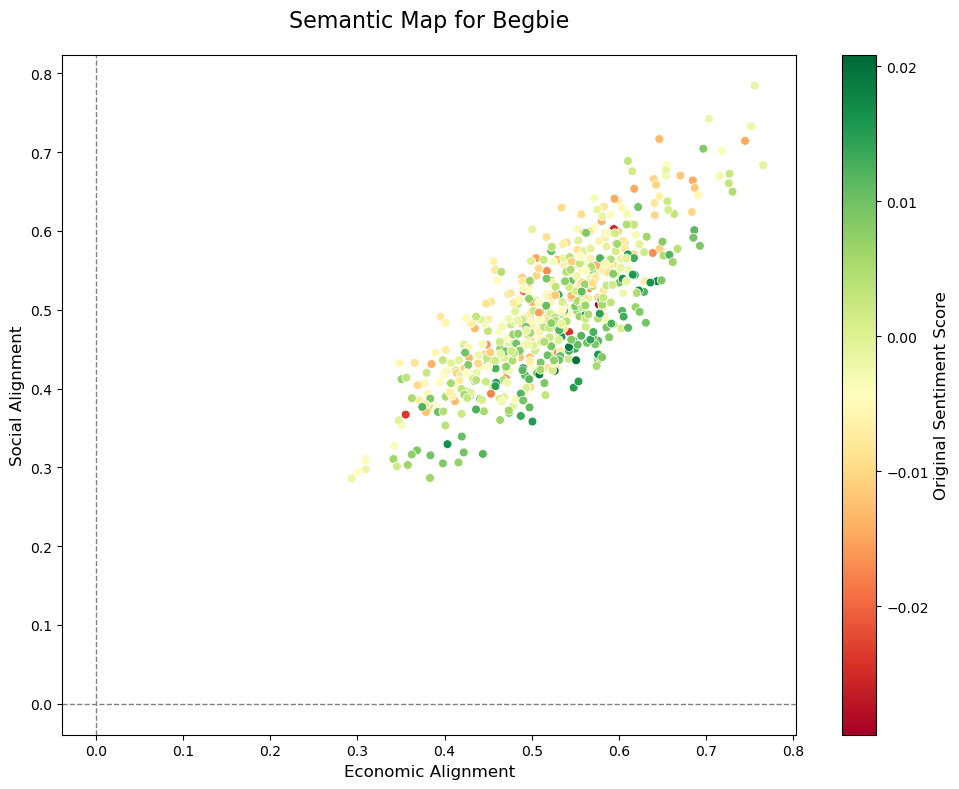

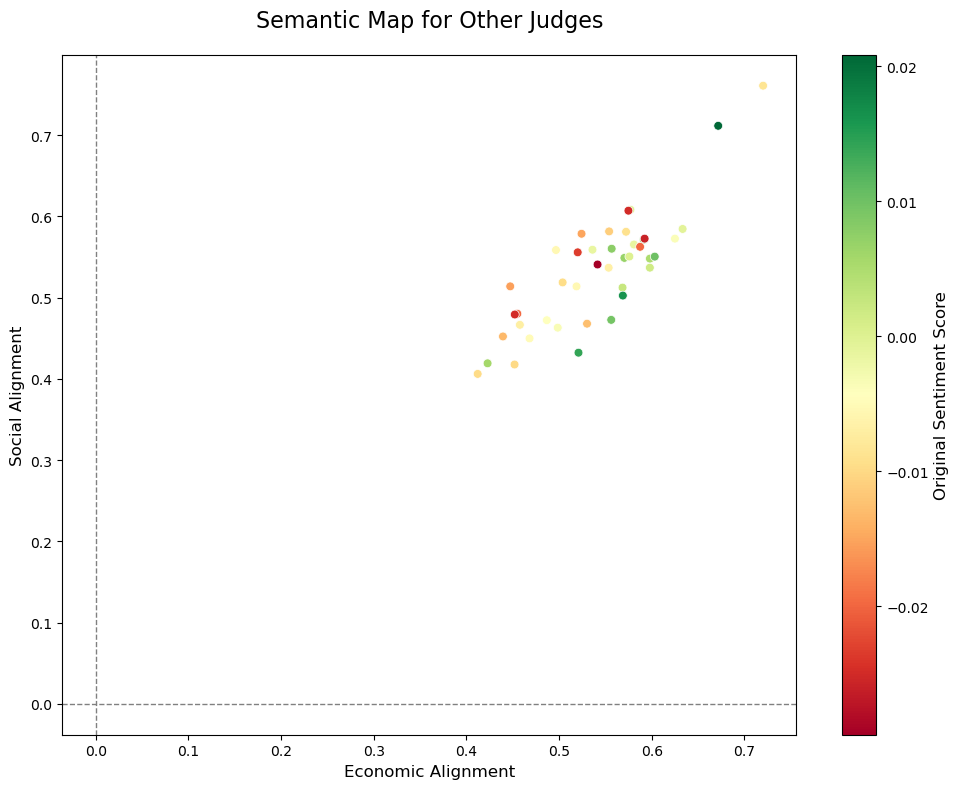

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
final_df['Sentiment_Normalized'] = scaler.fit_transform(final_df['Sentiment_Score'].values.reshape(-1, 1))

crease_df = final_df[final_df['Judge'] == 'Crease']
begbie_df = final_df[final_df['Judge'] == 'Begbie']
other_df = final_df[~final_df['Judge'].isin(['Crease', 'Begbie'])]

global_sentiment_min = final_df['Sentiment_Score'].min()
global_sentiment_max = final_df['Sentiment_Score'].max()

datasets_to_plot = {
    'Crease': crease_df,
    'Begbie': begbie_df,
    'Other Judges': other_df}

for name, data in datasets_to_plot.items():
    plt.figure(figsize=(10, 8))
    
    ax1 = sns.scatterplot(
        data=data,
        x='Economic_Alignment_Score',
        y='Social_Score',
        hue='Sentiment_Normalized',  
        palette='RdYlGn',
        s=40,
        legend=False 

    ax1.set_title(f'Semantic Map for {name}', fontsize=16, pad=20)
    ax1.set_xlabel('Economic Alignment', fontsize=12)
    ax1.set_ylabel('Social Alignment', fontsize=12)
    ax1.axhline(0, color='grey', linestyle='--', linewidth=1)
    ax1.axvline(0, color='grey', linestyle='--', linewidth=1)
    
    norm = plt.Normalize(vmin=global_sentiment_min, vmax=global_sentiment_max)
    sm = plt.cm.ScalarMappable(cmap="RdYlGn", norm=norm)
    sm.set_array([])
    
    cbar = plt.colorbar(sm, ax=ax1)
    cbar.set_label('Original Sentiment Score', size=12)

    plt.tight_layout()
    plt.show()


In [34]:
fig = px.scatter(
    final_df,
    x='Economic_Alignment_Score',
    y='Social_Score',
    color='Sentiment_Score',
    color_continuous_scale='RdYlGn',  # Red-Yellow-Green color scale
    range_color=[-0.02, 0.02], # You can adjust this range to better fit your data's spread
    title='Interactive Semantic Map of Sentences',
    # This part defines what appears when you hover over a point
    hover_data={
        'Sentence': True, # Show the full sentence text
        'Economic_Alignment_Score': ':.3f', # Format score to 3 decimal places
        'Social_Score': ':.3f',
        'Sentiment_Score': ':.3f'
    }
)

# Customize the hover label appearance
fig.update_traces(hoverlabel=dict(bgcolor="white", font_size=12))

# Add quadrant lines for context
fig.add_vline(x=0, line_width=1, line_dash="dash", line_color="grey")
fig.add_hline(y=0, line_width=1, line_dash="dash", line_color="grey")

# Update layout for a cleaner look
fig.update_layout(
    xaxis_title="Economic Alignment",
    yaxis_title="Social Alignment",
    coloraxis_colorbar_title_text='Sentiment'
)

fig.show()

c:\Users\Irene\miniconda3\envs\tlef-ai-312\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



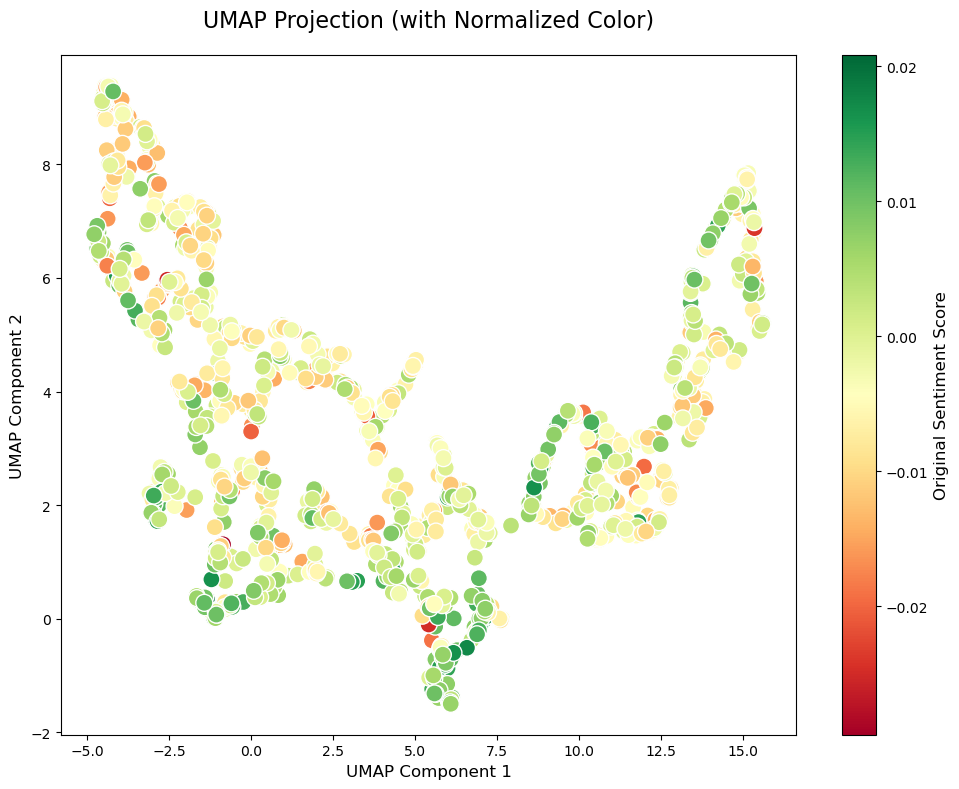

In [40]:
import umap

# --- UMAP and Plotting ---
numeric_cols = ['Economic_Alignment_Score', 'Social_Score', 'Sentiment_Score']
data_for_umap = final_df[numeric_cols].values
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(data_for_umap)
final_df['UMAP_1'] = embedding[:, 0]
final_df['UMAP_2'] = embedding[:, 1]

plt.figure(figsize=(10, 8))
ax2 = sns.scatterplot(
    data=final_df,
    x='UMAP_1',
    y='UMAP_2',
    hue='Sentiment_Normalized',
    palette='RdYlGn',
    s=150
)
ax2.set_title('UMAP Projection (with Normalized Color)', fontsize=16, pad=20)
ax2.set_xlabel('UMAP Component 1', fontsize=12)
ax2.set_ylabel('UMAP Component 2', fontsize=12)

# Manually create and add the colorbar
norm = plt.Normalize(final_df['Sentiment_Score'].min(), final_df['Sentiment_Score'].max())
sm = plt.cm.ScalarMappable(cmap="RdYlGn", norm=norm)
sm.set_array([])

# Remove the original legend created by seaborn
ax2.get_legend().remove()

# Add the new colorbar, specifying the axes
cbar = ax2.figure.colorbar(sm, ax=ax2) # <-- THIS IS THE CORRECTED LINE
cbar.set_label('Original Sentiment Score', size=12)

plt.tight_layout()
plt.show()

In [41]:
social_justice_keywords = ["rights", "equality", "morality", "race", "welfare"]

# Hand-code a small set of keywords for economics
economic_keywords = ["tax", "development", "trade", "business", "economy"]

In [42]:
social_justice_similarities = {}
for keyword in social_justice_keywords:
    if keyword in word_embeddings:
        social_justice_similarities[keyword] = {}
        for other_word, embedding in word_embeddings.items():
            if other_word != keyword:
                similarity = 1 - cosine(word_embeddings[keyword], embedding)
                social_justice_similarities[keyword][other_word] = similarity
                
# Sort by similarity score
social_justice_tokens = social_justice_keywords

for keyword, similarities in social_justice_similarities.items():
    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    print(f"Top 5 most similar words to '{keyword}':")
    for word, score in sorted_similarities[:5]:
        social_justice_tokens.append(word)
        print(f"{word}: {score:.4f}")
    print()

NameError: name 'word_embeddings' is not defined

In [ ]:
social_justice_anchor = np.mean([word_embeddings[word] for word in social_justice_tokens if word in word_embeddings], axis=0)
economic_anchor = np.mean([word_embeddings[word] for word in economic_tokens if word in word_embeddings], axis=0)

In [ ]:
def align_with_axis(embeddings, anchor, top_n=10):
    similarities = []
    for auth, snippets in judge_snippets.items():
        for snippet, emb in zip(snippets, embeddings_dict[auth]):
            similarity = cosine_similarity(emb.reshape(1, -1), anchor.reshape(1, -1))[0][0]
            similarities.append((auth, snippet, similarity))
    
    # Sort by similarity score and return top n results with author and snippet
    sorted_similarities = sorted(similarities, key=lambda x: x[2], reverse=True)
    return sorted_similarities[:top_n]

social_justice_top_sentences = align_with_axis(embeddings_dict, social_justice_anchor)
print("Top 10 sentences aligned with the social justice axis:\n")
for auth, snippet, score in social_justice_top_sentences:
    wrapped_para = textwrap.fill(snippet, width=100)
    print(f"Author: {auth}\nSentence: {wrapped_para}\nSimilarity Score: {score:.4f}\n")

In [ ]:
economic_top_sentences = align_with_axis(embeddings_dict, economic_anchor)

print("Top 10 sentences aligned with the economic axis:\n")
for auth, snippet, score in economic_top_sentences:
    wrapped_para = textwrap.fill(snippet, width=100)
    print(f"Author: {auth}\nSentence: {wrapped_para}\nSimilarity Score: {score:.4f}\n")

In [ ]:
import plotly.graph_objects as go

# Build the alignment DataFrame
alignment_rows = []
for auth, snippets in act_snippets.items():
    for snippet, emb in zip(snippets, embeddings_dict[auth]):
        sj_score = cosine_similarity(emb.reshape(1, -1), social_justice_anchor.reshape(1, -1))[0][0]
        econ_score = cosine_similarity(emb.reshape(1, -1), economic_anchor.reshape(1, -1))[0][0]
        alignment_rows.append({
            'Author': auth,
            'Text': wrap_text(snippet, width=60),
            'Social Justice Alignment': sj_score,
            'Economic Alignment': econ_score
        })
alignment_df = pd.DataFrame(alignment_rows)

# Compute mean alignment per author
mean_df = alignment_df.groupby('Author')[['Social Justice Alignment', 'Economic Alignment']].mean().reset_index()

# Base scatter plot of all snippets
fig = px.scatter(
    alignment_df,
    x='Social Justice Alignment',
    y='Economic Alignment',
    color='Author',
    hover_data=['Text'],
    title='Alignment of Sentences with Social Justice and Economic Axes',
    labels={
        'Social Justice Alignment': 'Social Justice Alignment',
        'Economic Alignment': 'Economic Alignment'
    },
    width=800,
    height=600
)

# Add mean points for each author
for _, row in mean_df.iterrows():
    fig.add_trace(
        go.Scatter(
            x=[row['Social Justice Alignment']],
            y=[row['Economic Alignment']],
            mode='markers+text',
            marker=dict(symbol='star', size=10, line=dict(width=1, color='Black')),
            text=[row['Author'] + ' Mean'],
            textposition='top center',
            showlegend=False
        )
    )

fig.update_traces(marker=dict(size=6), selector=dict(mode='markers'))
fig.update_layout(
    title='Alignment of Sentences with Social Justice and Economic Axes (with Author Means)',
    xaxis_title='Social Justice Alignment',
    yaxis_title='Economic Alignment'
)

fig.show()

In [ ]:


import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

# Prepare data for boxplots
authors = alignment_df['Author'].unique()
social_justice_data = [alignment_df[alignment_df['Author'] == author]['Social Justice Alignment'].values for author in authors]
economic_data = [alignment_df[alignment_df['Author'] == author]['Economic Alignment'].values for author in authors]

n_authors = len(authors)
positions_sj = [i - 0.2 for i in range(1, n_authors + 1)]
positions_econ = [i + 0.2 for i in range(1, n_authors + 1)]

# Create boxplots
bp1 = ax.boxplot(social_justice_data, positions=positions_sj, widths=0.3, patch_artist=True, 
                 tick_labels=None, boxprops=dict(facecolor='lightblue'))
bp2 = ax.boxplot(economic_data, positions=positions_econ, widths=0.3, patch_artist=True,
                 tick_labels=None, boxprops=dict(facecolor='lightgreen'))

# Set labels
ax.set_xticks(range(1, n_authors + 1))
ax.set_xticklabels(authors)

# Add labels and title
ax.set_xlabel('Author', fontsize=12)
ax.set_ylabel('Alignment Score', fontsize=12)
ax.set_title('Social Justice vs Economic Alignment by Author', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Social Justice Alignment', 'Economic Alignment'])

plt.tight_layout()
plt.show()



# Regressions

In [138]:
print(results_df)

       Judge                                           Sentence  Social_Score  \
0     Crease  14th & 15th July, Certiorari—“Chinese Regulati...      0.488737   
1     Crease                              5—Constitutionality—B      0.616317   
2     Crease                                      Act, 1867, ss      0.495978   
3     Crease      91, 92—“Aliens”—“Trade and Commerce”—Taxation      0.554244   
4     Crease              On the return to a writ of certiorari      0.607982   
...      ...                                                ...           ...   
1179   other  The Lieutenant-Governor in Council may, by any...      0.518521   
1180   other  The Lieutenant-Governor in Council may also ma...      0.485524   
1181   other  For the purpose of any proceeding taken under ...      0.464795   
1182   other  This Act shall not come into operation until o...      0.459314   
1183   other  This Act may be cited as the "Chinese Regulati...      0.564329   

      Econ_Score  Sentiment

We can test to what extent the effect of social score on sentiment depends on the Judge

In [143]:
results_df['is_crease'] = (results_df['Judge'] == 'Crease').astype(int)

In [144]:
import pandas as pd
import statsmodels.formula.api as smf
reg = "Sentiment ~ Social_Score * is_crease + Econ_Score * is_crease"
model = smf.ols(reg, data=results_df)
model_fit = model.fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:              Sentiment   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     5.810
Date:                Wed, 30 Jul 2025   Prob (F-statistic):           2.62e-05
Time:                        21:22:49   Log-Likelihood:                -1564.1
No. Observations:                1184   AIC:                             3140.
Df Residuals:                    1178   BIC:                             3171.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

In [145]:
results_df['is_begbie'] = (results_df['Judge'] == 'Begbie').astype(int)

reg = "Sentiment ~ Social_Score * is_begbie + Econ_Score * is_begbie"
model = smf.ols(reg, data=results_df)
model_fit = model.fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:              Sentiment   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     5.401
Date:                Wed, 30 Jul 2025   Prob (F-statistic):           6.42e-05
Time:                        21:24:19   Log-Likelihood:                -1565.1
No. Observations:                1184   AIC:                             3142.
Df Residuals:                    1178   BIC:                             3173.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0

pretty terrible

# non-ml tf-idf

In [153]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Irene\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Irene\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [43]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Irene\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Irene\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

someone please fix to use nltk libeary, nltk.download() doesnt work for me

In [52]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords

try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

# --- Main Function ---
def preprocess_text(text_string):
    """
    Cleans and preprocesses text by:
    1. Converting to lowercase
    2. Removing punctuation and numbers
    3. Tokenizing
    4. Removing stop words (standard + custom)
    5. Removing words with 4 or fewer characters
    """
    # Start with the standard English stop words
    stop_words = set(stopwords.words('english'))
    
    # Add custom domain-specific stop words if needed
    custom_additions = {'would', 'may', 'act', 'mr', 'sir', 'also', 'upon', 'shall'}
    stop_words.update(custom_additions)
    
    # 1. & 2. Lowercase and remove non-alphabetic characters
    processed_text = text_string.lower()
    processed_text = re.sub(r'[^a-z\s]', '', processed_text)
    
    # 3. Tokenize
    tokens = processed_text.split()
    
    # 4. & 5. Filter out stop words AND short words in a single step
    filtered_tokens = [
        word for word in tokens 
        if word not in stop_words and len(word) > 4
    ]
    
    # Re-join the words into a single string
    return " ".join(filtered_tokens)

df['processed_text'] = df['text'].apply(preprocess_text)

print(df)


                               filename       author    type  \
0               regina_v_wing_chong.txt       Crease    case   
1            wong_hoy_woon_v_duncan.txt       Crease    case   
2                  regina_v_mee_wah.txt       Begbie    case   
3                 regina_v_victoria.txt       Begbie    case   
4             quong_wing_v_the_king.txt  Fitzpatrick    case   
5  commission_on_chinese_imigration.txt       Powell  report   
6            chapleau_report_resume.txt     Chapleau  report   
7                 crease_commission.txt       Crease  report   
8                 begbie_commission.txt       Begbie  report   
9       chinese_regulation_act_1884.txt       Others     act   

                                                text  \
0  CREASE, J. 1885. REGINA v. WING CHONG. \r\n\r\...   
1  CREASE, J.\r\n\r\nWONG HOY WOON v. DUNCAN.\r\n...   
2  BRITISH COLUMBIA REPORTS.\r\n\r\nREGINA v. MEE...   
3  OF BRITISH COLUMBIA.\r\n\r\nREGINA r, CORPORAT...   
4  QUONG WING v

In [46]:
print(df)

                               filename       author    type  \
0               regina_v_wing_chong.txt       Crease    case   
1            wong_hoy_woon_v_duncan.txt       Crease    case   
2                  regina_v_mee_wah.txt       Begbie    case   
3                 regina_v_victoria.txt       Begbie    case   
4             quong_wing_v_the_king.txt  Fitzpatrick    case   
5  commission_on_chinese_imigration.txt       Powell  report   
6            chapleau_report_resume.txt     Chapleau  report   
7                 crease_commission.txt       Crease  report   
8                 begbie_commission.txt       Begbie  report   
9       chinese_regulation_act_1884.txt       Others     act   

                                                text  \
0  CREASE, J. 1885. REGINA v. WING CHONG. \r\n\r\...   
1  CREASE, J.\r\n\r\nWONG HOY WOON v. DUNCAN.\r\n...   
2  BRITISH COLUMBIA REPORTS.\r\n\r\nREGINA v. MEE...   
3  OF BRITISH COLUMBIA.\r\n\r\nREGINA r, CORPORAT...   
4  QUONG WING v

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [54]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming 'df' is your pre-existing DataFrame with 'processed_text' and 'author' columns
# df = pd.read_csv('your_data.csv') 
# df['processed_text'] = df['text'].apply(preprocess_text) # Your preprocessing function

# 1. Create the 'group' column as before
df['group'] = 'Other'
df.loc[df['author'] == 'Crease', 'group'] = 'Crease'
df.loc[df['author'] == 'Begbie', 'group'] = 'Begbie'

# --- The Improved Method ---

# 2. Vectorize the entire corpus of individual documents FIRST
# This calculates IDF based on word rarity across ALL individual texts.
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 3))
tfidf_matrix = vectorizer.fit_transform(df['processed_text'])

# 3. Create a new DataFrame with the TF-IDF scores
# Each row is a document, each column is a word/ngram
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# 4. Add the 'group' column to this TF-IDF DataFrame for aggregation
tfidf_df['group'] = df['group'].values

# 5. Group by author and calculate the MEAN TF-IDF score for each word
# This finds the words that are, on average, most important for each group.
mean_tfidf_by_group = tfidf_df.groupby('group').mean()

# 6. Display the top words for each group
for group_name in ['Crease', 'Begbie', 'Other']:
    print(f' author: {group_name}')
    # Sort the mean scores for the current group
    top_words = mean_tfidf_by_group.loc[group_name].sort_values(ascending=False).head(10)
    print(top_words)
    print("\n")


 author: Crease
chinese           0.230631
labor             0.169053
infected          0.135792
white             0.130238
hongkong          0.096994
british           0.096865
health officer    0.090528
taxation          0.090515
china             0.087631
health            0.085515
Name: Crease, dtype: float64


 author: Begbie
license         0.229377
chinamen        0.151469
licenses        0.133878
municipality    0.114421
statute         0.104238
legislature     0.098943
revenue         0.097536
corporation     0.093994
pawnbrokers     0.085816
provincial      0.084627
Name: Begbie, dtype: float64


 author: Other
chinese        0.261389
canada         0.175249
legislation    0.103596
country        0.085820
county         0.085506
naturalized    0.081062
british        0.079940
great          0.078513
parliament     0.074784
honorable      0.073703
Name: Other, dtype: float64




In [57]:
# 6. Collect top words and arrange them into a side-by-side DataFrame
list_of_author_dfs = []
for group_name in ['Crease', 'Begbie', 'Other']:
    # Get the top 10 terms and scores for the current author
    top_words = mean_tfidf_by_group.loc[group_name].sort_values(ascending=False).head(10)
    
    # Convert the Series to a DataFrame
    top_words_df = top_words.reset_index()
    
    # Rename the columns to be specific to this author
    # This creates one column for the term and one for the score
    top_words_df.columns = [group_name, f'{group_name}_score']
    
    list_of_author_dfs.append(top_words_df)

# Concatenate the list of DataFrames horizontally (axis=1)
final_wide_df = pd.concat(list_of_author_dfs, axis=1)

# Display the final combined DataFrame
final_wide_df

,Crease,Crease_score,Begbie,Begbie_score,Other,Other_score
0,chinese,0.230631,license,0.229377,chinese,0.261389
1,labor,0.169053,chinamen,0.151469,canada,0.175249
2,infected,0.135792,licenses,0.133878,legislation,0.103596
3,white,0.130238,municipality,0.114421,country,0.085820
4,hongkong,0.096994,statute,0.104238,county,0.085506
5,british,0.096865,legislature,0.098943,naturalized,0.081062
6,health officer,0.090528,revenue,0.097536,british,0.079940
7,taxation,0.090515,corporation,0.093994,great,0.078513
8,china,0.087631,pawnbrokers,0.085816,parliament,0.074784
9,health,0.085515,provincial,0.084627,honorable,0.073703
